## Implementation for Medium blog post on Bilinear pooling

In [1]:
import numpy as np
from scipy.stats import cauchy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Layer
from keras.layers import Input, Dense, Activation, Reshape, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import accuracy_score as acc
import os

## Reading the data.
The current example uses small datasets and serves only illustratory purposes.

In [2]:
# Model / data parameters
input_shape = (28, 28, 1)

# the data, split between train and test sets
# Fashion MNIST
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.fashion_mnist.load_data()

# MNIST
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

num_classes = len(np.unique(y_train) + np.unique(y_test))
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices, used for cross entropy loss
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

print(y_train.shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(60000, 10)


In [3]:
class bili_regularizer_l2(regularizers.Regularizer):
    '''
        Standard L2 regularization applied to the weight matrix for the bilinear layer.
    '''
    def __init__(self, strength):
        self.strength = strength

    def __call__(self, weights):
        w0 = weights[0]
        w1 = weights[1]
        # d = 3 # w0.shape[2]
        #z = tf.norm(w0, ord=2) + tf.norm(w1, ord=2) 
        T1 = tf.matmul(tf.transpose(w0, perm=[0,2,1]), w0)
        T2 = tf.matmul(tf.transpose(w1, perm=[0,2,1]), w1) 
        z = tf.linalg.trace(tf.matmul(T1, T2))
        # print("z = ", tf.reduce_sum(z))
        return self.strength * tf.reduce_sum(z) 

In [4]:
class bilinear_layer(Layer):
    def __init__(self, num_outputs, channels_X, channels_Y, regularizer, d, rank, seed=1):
        super(bilinear_layer, self).__init__()
        self.num_outputs = num_outputs
        self.channels_X = channels_X # the number of features in the first NN (m in the blog post)
        self.channels_Y = channels_Y # the number of features in the second NN (n in the blog post)
        self.d = d # the dimensionality of the feature maps
        self.rank = rank # the rank of the low-rank matrices
        self.kernel_regularizer = regularizer 

    def build(self, input_shape):
        
        tf.random.set_seed(1)
        self.w = self.add_weight(shape=(2, self.num_outputs, self.channels_X, self.rank),
                                    initializer="random_normal",
                                    trainable=True,
                                    regularizer=self.kernel_regularizer)
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(self.num_outputs,), dtype="float32"), trainable=True
        )
        
    def call(self, inputs):
        X, Y = inputs[0], inputs[1]       
        X = tf.reshape(X, (-1, 1, self.channels_X, self.d*self.d)) 
        Y = tf.reshape(Y,  (-1, 1, self.channels_Y, self.d*self.d)) 
        T1 = tf.matmul(tf.transpose(X, perm=[0,1,3,2]), self.w[0])
        T2 = tf.matmul(tf.transpose(self.w[1], perm=[0,2,1]), Y) 
        
        # The matrix trace takes only the diagonal entries. 
        # The expression below computes sum_{i=1}^d u_i^TW_k v_i from the blog post
        z = tf.linalg.trace(tf.matmul(T1, T2))/(self.d*self.d) + self.b
        softmax = tf.keras.layers.Softmax()
        z = softmax(z)
        return z 

In [5]:
inp = Input(shape=(28, 28, 1))
x = Conv2D(32, kernel_size=(3, 3), activation="relu", name="conv1", padding="same")(inp)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation="relu", name="conv2", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)


bili_reg = bili_regularizer_l2(strength=1)
bili_layer = bilinear_layer(num_outputs=num_classes,
              channels_X=32,
              channels_Y=32,
              regularizer = bili_reg, 
              rank = 8,
              d = x.shape[1] 
              )
x = bili_layer([x, x])
model = tf.keras.Model(inputs=[inp], outputs=[x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 14, 14, 32)   9248        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
batch_size = 128
epochs = 15
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])#, run_eagerly = False)
training_hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                          validation_split=0.1, callbacks=[callback])

Epoch 1/15
422/422 [==============================] - 34s 80ms/step - loss: 1.5108 - accuracy: 0.4818 - val_loss: 0.8500 - val_accuracy: 0.7228
Epoch 2/15
422/422 [==============================] - 37s 87ms/step - loss: 0.7645 - accuracy: 0.7438 - val_loss: 0.8157 - val_accuracy: 0.7413
Epoch 3/15
422/422 [==============================] - 46s 108ms/step - loss: 0.6766 - accuracy: 0.7767 - val_loss: 0.7179 - val_accuracy: 0.7587
Epoch 4/15
422/422 [==============================] - 36s 86ms/step - loss: 0.6280 - accuracy: 0.7896 - val_loss: 0.6679 - val_accuracy: 0.7705
Epoch 5/15
422/422 [==============================] - 39s 92ms/step - loss: 0.5878 - accuracy: 0.8016 - val_loss: 0.6463 - val_accuracy: 0.7805
Epoch 6/15
422/422 [==============================] - 35s 83ms/step - loss: 0.5582 - accuracy: 0.8117 - val_loss: 0.6273 - val_accuracy: 0.7633
Epoch 7/15
422/422 [==============================] - 37s 89ms/step - loss: 0.5429 - accuracy: 0.8149 - val_loss: 0.5751 - val_accuracy

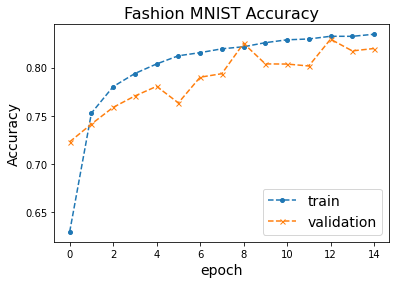

In [7]:
plt.plot(training_hist.history['accuracy'], marker='o', markersize=4, linestyle='--')
plt.plot(training_hist.history['val_accuracy'], marker='x', markersize=5, linestyle='--')
plt.title('Fashion MNIST Accuracy',fontsize=16)
plt.ylabel('Accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'validation'], loc='lower right',fontsize=14)
plt.show()

In [8]:
y_pred = model.predict(x_test)
print("Accuracy on test set", acc(y_test, np.argmax(y_pred, axis=1)))

Accuracy on test set 0.8151
